# Recipe Recommendation System

### The Data

In [1]:
import pandas as pd
import numpy as np
import re
import spacy
import ast

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# recipes = pd.concat([allrecipes, epicurious, foodnetwork]).reset_index(drop=True) # Concat does not reset indices
recipes = pd.read_csv('/content/drive/MyDrive/Info Retrieval/full_dataset.csv', index_col=0, nrows=10000)
print(recipes.shape)
recipes.head()

(10000, 6)


,title,ingredients,directions,link,source,NER
0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."


In [9]:
recipes['instructions'] = recipes['directions'].apply(lambda x: ' '.join(ast.literal_eval(x)))

In [10]:
recipes = recipes.rename(columns={'link': 'picture_link'})
recipes = recipes.drop(labels = ['directions', 'source', 'NER'], axis=1)
recipes.head()

,title,ingredients,picture_link,instructions
0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...",www.cookbooks.com/Recipe-Details.aspx?id=44874,"In a heavy 2-quart saucepan, mix brown sugar, ..."
1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...",www.cookbooks.com/Recipe-Details.aspx?id=699419,Place chipped beef on bottom of baking dish. P...
2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...",www.cookbooks.com/Recipe-Details.aspx?id=10570,"In a slow cooker, combine all ingredients. Cov..."
3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Boil and debone chicken. Put bite size pieces ...
4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Combine first four ingredients and press in 13...


In [11]:
# Count of missing values by category
recipes.isna().sum()

,0
title,0
ingredients,0
picture_link,0
instructions,0


In [12]:
recipes.dtypes

,0
title,object
ingredients,object
picture_link,object
instructions,object


In [13]:
# Recipe instructions with less than 20 characters are not good recipes
empty_instr_ind = [index for i, index in zip(recipes['instructions'], recipes.index) if len(i) < 20]
for i in empty_instr_ind:
    print(recipes.loc[i, ['title', 'instructions']])
recipes = recipes.drop(index = empty_instr_ind).reset_index(drop=True)

title              Blonde Brownies
instructions    Mix; bake at 325°.
Name: 2586, dtype: object
title           Puffed Wheat Cake
instructions      Cook 3 1/2 min.
Name: 5505, dtype: object


In [14]:
recipes.shape

(9998, 4)

In [15]:
recipes.isna().sum()

,0
title,0
ingredients,0
picture_link,0
instructions,0


In [16]:
# Checking for low ingredient recipes.
#low_ingr_ind = [index for i, index in zip(recipes['ingredients'], recipes.index) if len(i) < 20]
low_ingr_index = [index for i, index in zip(recipes['ingredients'], recipes.index) if i[0] == np.nan]
len(low_ingr_index)
recipes.loc[low_ingr_index, 'ingredients']

,ingredients


### Cleaning to Prepare for Tokenizing

In [17]:
# Removing ADVERTISEMENT text from ingredients list
ingredients = []
for ing_list in recipes['ingredients']:
    clean_ings = [ing.replace('ADVERTISEMENT','').strip() for ing in ast.literal_eval(ing_list)]
    if '' in clean_ings:
        clean_ings.remove('')
    ingredients.append(clean_ings)
recipes['ingredients'] = ingredients

In [18]:
recipes.loc[0,'ingredients']

['1 c. firmly packed brown sugar',
 '1/2 c. evaporated milk',
 '1/2 tsp. vanilla',
 '1/2 c. broken nuts (pecans)',
 '2 Tbsp. butter or margarine',
 '3 1/2 c. bite size shredded rice biscuits']

In [19]:
# Extracting ingredients from their lists and formatting as single strings
recipes['ingredient_text'] = ['; '.join(ingredients) for ingredients in recipes['ingredients']]
recipes['ingredient_text'].head()

,ingredient_text
0,1 c. firmly packed brown sugar; 1/2 c. evapora...
1,"1 small jar chipped beef, cut up; 4 boned chic..."
2,2 (16 oz.) pkg. frozen corn; 1 (8 oz.) pkg. cr...
3,1 large whole chicken; 2 (10 1/2 oz.) cans chi...
4,1 c. peanut butter; 3/4 c. graham cracker crum...


In [20]:
# Counting the number of ingredients used in each recipe
recipes['ingredient_count'] = [len(ingredients) for ingredients in recipes['ingredients']]

In [21]:
recipes.head()

,title,ingredients,picture_link,instructions,ingredient_text,ingredient_count
0,No-Bake Nut Cookies,"[1 c. firmly packed brown sugar, 1/2 c. evapor...",www.cookbooks.com/Recipe-Details.aspx?id=44874,"In a heavy 2-quart saucepan, mix brown sugar, ...",1 c. firmly packed brown sugar; 1/2 c. evapora...,6
1,Jewell Ball'S Chicken,"[1 small jar chipped beef, cut up, 4 boned chi...",www.cookbooks.com/Recipe-Details.aspx?id=699419,Place chipped beef on bottom of baking dish. P...,"1 small jar chipped beef, cut up; 4 boned chic...",4
2,Creamy Corn,"[2 (16 oz.) pkg. frozen corn, 1 (8 oz.) pkg. c...",www.cookbooks.com/Recipe-Details.aspx?id=10570,"In a slow cooker, combine all ingredients. Cov...",2 (16 oz.) pkg. frozen corn; 1 (8 oz.) pkg. cr...,6
3,Chicken Funny,"[1 large whole chicken, 2 (10 1/2 oz.) cans ch...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Boil and debone chicken. Put bite size pieces ...,1 large whole chicken; 2 (10 1/2 oz.) cans chi...,5
4,Reeses Cups(Candy),"[1 c. peanut butter, 3/4 c. graham cracker cru...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Combine first four ingredients and press in 13...,1 c. peanut butter; 3/4 c. graham cracker crum...,5


In [22]:
all_text = recipes['title'] + ' ' + recipes['ingredient_text'] + ' ' + recipes['instructions']
all_text[0]

'No-Bake Nut Cookies 1 c. firmly packed brown sugar; 1/2 c. evaporated milk; 1/2 tsp. vanilla; 1/2 c. broken nuts (pecans); 2 Tbsp. butter or margarine; 3 1/2 c. bite size shredded rice biscuits In a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine. Stir over medium heat until mixture bubbles all over top. Boil and stir 5 minutes more. Take off heat. Stir in vanilla and cereal; mix well. Using 2 teaspoons, drop and shape into 30 clusters on wax paper. Let stand until firm, about 30 minutes.'

In [23]:
# Clean_text Function
import string
import re

def clean_text(documents):
    cleaned_text = []
    for doc in documents:
        doc = doc.translate(str.maketrans('', '', string.punctuation)) # Remove Punctuation
        doc = re.sub(r'\d+', '', doc) # Remove Digits
        doc = doc.replace('\n',' ') # Remove New Lines
        doc = doc.strip() # Remove Leading White Space
        doc = re.sub(' +', ' ', doc) # Remove multiple white spaces
        cleaned_text.append(doc)
    return cleaned_text

# Cleaning Text
cleaned_text = clean_text(all_text)

In [24]:
cleaned_text[0]

'NoBake Nut Cookies c firmly packed brown sugar c evaporated milk tsp vanilla c broken nuts pecans Tbsp butter or margarine c bite size shredded rice biscuits In a heavy quart saucepan mix brown sugar nuts evaporated milk and butter or margarine Stir over medium heat until mixture bubbles all over top Boil and stir minutes more Take off heat Stir in vanilla and cereal mix well Using teaspoons drop and shape into clusters on wax paper Let stand until firm about minutes'

### Tokenizing Using Spacy

In [25]:
# Testing Strategies and Code
nlp = spacy.load('en_core_web_sm')

' '.join([token.lemma_ for token in nlp(cleaned_text[0]) if not token.is_stop])

'nobake Nut Cookies c firmly pack brown sugar c evaporate milk tsp vanilla c broken nuts pecans Tbsp butter margarine c bite size shred rice biscuit heavy quart saucepan mix brown sugar nuts evaporate milk butter margarine Stir medium heat mixture bubble Boil stir minute heat Stir vanilla cereal mix teaspoon drop shape cluster wax paper let stand firm minute'

In [26]:
# Tokenizing Function that lemmatizes words and removes Stop Words
def text_tokenizer(documents):
    tokenized_documents = []
    for doc in documents:
        tok_doc = ' '.join([token.lemma_ for token in nlp(doc) if not token.is_stop])
        tokenized_documents.append(tok_doc)
    return tokenized_documents

In [27]:
# Tokenizing Function to run in parallel
def text_tokenizer_mp(doc):
    tok_doc = ' '.join([token.lemma_ for token in nlp(doc) if not token.is_stop])
    return tok_doc

In [28]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  2


In [29]:
# Parallelzing tokenizing process
pool = mp.Pool(mp.cpu_count())
tokenized_text = pool.map(text_tokenizer_mp, [doc for doc in cleaned_text])

In [30]:
# Save the tokenized_text variable as a csv in order to return to it;
# Do not attempt to run the parser above, it will simply take too long
# Reload the csv from file insted
pd.Series(tokenized_text).to_csv('tokenized_text.csv')

In [31]:
tokenized_text[0]

'nobake Nut Cookies c firmly pack brown sugar c evaporate milk tsp vanilla c broken nuts pecans Tbsp butter margarine c bite size shred rice biscuit heavy quart saucepan mix brown sugar nuts evaporate milk butter margarine Stir medium heat mixture bubble Boil stir minute heat Stir vanilla cereal mix teaspoon drop shape cluster wax paper let stand firm minute'

### Creating Word Embeddings

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(lowercase = True,
                            ngram_range = (1,1))

text_tfidf = vectorizer.fit_transform(tokenized_text)
tfidf_words = vectorizer.get_feature_names_out()
print(text_tfidf.shape)
print(len(tfidf_words))

(9998, 6520)
6520


## Topic Modeling

In [33]:
text_tfidf.shape

(9998, 6520)

In [34]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components = 50,
          n_jobs = -1,
          max_iter = 100)
text_lda = lda.fit_transform(text_tfidf)
text_lda.shape

(9998, 50)

In [35]:
from sklearn.decomposition import NMF

nmf = NMF(alpha_W=0.0,
         init='nndsvdar',
         l1_ratio=0.0,
         max_iter = 500,
         n_components = 50,
         solver='cd')

text_nmf = nmf.fit_transform(text_tfidf)
text_nmf.shape

(9998, 50)

## Exploring Topics by Document

In [36]:
# variable dependencies:
text_series = pd.Series(all_text)

def docs_by_tops(top_mat, topic_range = (0,0), doc_range = (0,2)):
    for i in range(topic_range[0], topic_range[1]):
        topic_scores = pd.Series(top_mat[:,i])
        doc_index = topic_scores.sort_values(ascending = False)[doc_range[0]:doc_range[1]].index
        for j, index in enumerate(doc_index, doc_range[0]):
            print('Topic #{}'.format(i),
                  '\nDocument #{}'.format(j),
                  '\nTopic Score: {}\n\n'.format(topic_scores[index]),
                  text_series[index], '\n\n')

In [37]:
docs_by_tops(text_lda,(0,3),(0,3))

Topic #0 
Document #0 
Topic Score: 0.43007700278226135

 Mrs. Levy'S Lemon Love Notes 1 c. butter; 2 c. flour; 1/2 c. powdered sugar Mix and press into 9 x 13-inch pan. Bake at 325°. 


Topic #0 
Document #1 
Topic Score: 0.4018497265879504

 Mozzarella Cheese 2 gal. fresh goat milk; 1 c. buttermilk (I use Meadowbrook dairy buttermilk); 2 Rennet (Junket) tablets, dissolved in a little cold water; salt A simple cheese recipe. This vinegar cheese is easy to make and doesn't require fancy equipment. 


Topic #0 
Document #2 
Topic Score: 0.27794307198981705

 Peanut Brittle 1 c. sugar; 1/4 c. hot water; salt; 1/2 c. white Karo; vanilla Cook all until spins a thread. Add 2 cups raw peanuts. Cook until pops and browns. Add teaspoon soda, pour on buttered cookie sheet. As soon as able to handle, pull onto buttered tabletop. 


Topic #1 
Document #0 
Topic Score: 0.4745425963223447

 Play Dough 1 c. flour; 2 tsp. cream of tartar (most important, do not omit); 1 Tbsp. salad oil; 1/2 c. salt; 

In [38]:
docs_by_tops(text_nmf,(0,3),(0,3))

Topic #0 
Document #0 
Topic Score: 0.0441660776854756

 Buttermilk Cake 1 c. Crisco; 3 c. sugar; 1 c. eggs (5, whole); 1 c. buttermilk; 3 c. flour; 1/2 tsp. salt; 1/2 tsp. soda; 2 tsp. vanilla Mix shortening, sugar and eggs alternately putting in flour and buttermilk. Grease and flour middle and bottom of pan. Bake 1 1/2 hours at 325°. 


Topic #0 
Document #1 
Topic Score: 0.04396820841014746

 Buttermilk Pound Cake 1 c. Crisco; 3 c. sugar; 5 eggs; 3 c. flour; 1/4 tsp. salt; 1 c. buttermilk; 1/2 tsp. soda; 1 tsp. vanilla Cream sugar and shortening; add eggs, one at a time, beating well after each. Sift together flour and salt. Mix soda and buttermilk. Add alternately the milk and flour to first mixture. Beat in vanilla; bake at 350° for 1 hour (the original recipe says 1 hour and 20 minutes but that's too long in my oven). 


Topic #0 
Document #2 
Topic Score: 0.04239816594266421

 Buttermilk Biscuits 2 c. flour; 1 tsp. salt; 2 tsp. baking powder; 1 tsp. sugar; 1/2 tsp. soda; 1/4 c.

In [39]:
docs_by_tops(text_nmf,(1,2),(90000,90001))

### Exploring Topics by words

In [40]:
text_nmf.shape

(9998, 50)

In [41]:
text_tfidf.T.shape

(6520, 9998)

In [42]:
# Function for best topic words using cosine similarity
# Variable Dependency:
word_series = pd.Series(tfidf_words)

def words_by_tops(tfidf_mat, top_mat, topic_range=(0,0), n_words=10):
    topic_word_scores = tfidf_mat.T * top_mat
    for i in range(topic_range[0],topic_range[1]):
        word_scores = pd.Series(topic_word_scores[:,i])
        word_index = word_scores.sort_values(ascending = False)[:n_words].index
        print('\nTopic #{}'.format(i))
        for index in word_index:
            print(word_series[index],'\t\t', word_scores[index])

In [43]:
# Keywords using LDA
words_by_tops(text_tfidf, text_lda, (0,3), 10)


Topic #0
tsp 		 3.2074210169838304
sugar 		 2.440503136394399
add 		 2.0984353177940305
pepper 		 2.071932956392762
salt 		 2.055477396918098
bake 		 2.0120752353575497
egg 		 1.9956188855110533
chop 		 1.9893244960308398
onion 		 1.97674460862506
tbsp 		 1.927288723645294

Topic #1
tsp 		 2.5730752714841696
sugar 		 2.209529875763084
bake 		 1.7659319977104846
add 		 1.7404169740446578
egg 		 1.736638979335014
butter 		 1.7247771557156584
cheese 		 1.6729457148765474
mix 		 1.6593641030079576
flour 		 1.6496398831498968
cream 		 1.5696709098368546

Topic #2
cake 		 54.644119658773036
whip 		 41.37429078661943
pudding 		 37.637532891950514
cool 		 36.444987238817816
mix 		 34.56096106478844
cream 		 30.563161565644688
sugar 		 27.062794216285724
oz 		 26.507712070315687
cracker 		 25.070685056014426
graham 		 23.809452156106396


In [44]:
# Words using NMF
words_by_tops(text_tfidf, text_nmf, (0,3), 10)


Topic #0
flour 		 5.589282223548514
tsp 		 4.851694195302441
sugar 		 4.07635681027915
bake 		 3.843447266437432
egg 		 3.7686191907249773
soda 		 3.3603891418068605
add 		 2.835618197523376
vanilla 		 2.441648746857123
salt 		 2.42107215074725
butter 		 2.2256365216104945

Topic #1
beef 		 7.769342476725464
ground 		 5.045811411249011
onion 		 4.623262208500087
meat 		 4.254031511918164
lb 		 4.145119064451819
pepper 		 3.4531708060271304
tsp 		 3.257331348539831
sauce 		 3.2472616629105753
tomato 		 2.8995771079750776
brown 		 2.787570435728874

Topic #2
whip 		 6.786199727343367
cool 		 5.785965253026512
pudding 		 4.650778691603197
cream 		 3.1599290687788306
mix 		 2.909796445446515
oz 		 2.882402638023304
cake 		 2.778838760439962
sugar 		 2.756448219094472
milk 		 2.4727435573718597
instant 		 2.363886369002764


### Keyword Extraction of Topics Using TextRank

In [45]:
# Pulling the top one-hundred documents ranked in similarity among Topic #1
text_index = pd.Series(text_nmf[:,1]).sort_values(ascending = False)[:100].index
text_4summary = pd.Series(cleaned_text)[text_index]

# Manually Creating a list of recipe stop
recipe_stopwords = ['cup','cups','ingredient','ingredients','teaspoon','tablespoon','oven']


In [46]:
# generating topic filter
import time
start_time = time.time()

parsed_texts = nlp(' '.join(text_4summary))
kw_filts = set([str(word) for word in parsed_texts
                if (word.pos_== ('NOUN' or 'ADJ' or 'VERB'))
                and str(word) not in recipe_stopwords])

timee = time.time() - start_time
print(f'Execution Time: {timee} seconds')


Execution Time: 2.7484233379364014 seconds


In [47]:
temp = []
for i in kw_filts:
  temp.append(i.lower())

In [48]:
len(list(set(kw_filts)))

316

In [49]:
kw_filts_unique = list(set(temp))
print(len(kw_filts_unique))

305


In [50]:
# Creating adjecency Table for recipes.
adjacency = pd.DataFrame(columns=kw_filts_unique, index=kw_filts_unique, data = 0)
for i, word in enumerate(parsed_texts):
    if str(word) in kw_filts_unique:
        end = min(len(parsed_texts), i+5)  # Window of four words
        nextwords = parsed_texts[i+1:end]
        inset = [str(x) in kw_filts_unique for x in nextwords]
        neighbors = [str(nextwords[i]) for i in range(len(nextwords)) if inset[i]]
        if neighbors:
          # print(str(word), neighbors)
          for i in neighbors:
            adjacency.loc[str(word), i] += 1

In [51]:
adjacency

,drop,sides,ground,season,box,z,thyme,whites,skillet,vinegar,...,rice,tapioca,currant,grease,bag,meal,roast,broth,sausage,remainder
drop,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sides,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ground,0,0,8,0,0,0,0,0,8,1,...,2,0,0,0,0,0,0,0,2,0
season,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
box,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
meal,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
roast,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
broth,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sausage,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
import networkx as nx

# Running TextRank
nx_words = nx.from_numpy_array(adjacency.values)
ranks=nx.pagerank(nx_words, alpha=.85, tol=.00000001)

# Identifying the most highly ranked keywords
ranked = sorted(((ranks[i],s) for i,s in enumerate(kw_filts_unique)),
                reverse=True)

In [53]:
ranked[:25]

[(0.037609186989229826, 'beef'),
 (0.03715009371579529, 'c'),
 (0.029782201068221395, 'tsp'),
 (0.026229891817769198, 'can'),
 (0.025657761438126415, 'pepper'),
 (0.023372548068052747, 'salt'),
 (0.022514176665592193, 'ground'),
 (0.022264851913118396, 'onion'),
 (0.020886748803119002, 'oz'),
 (0.018166636746824467, 'sauce'),
 (0.01520719889733808, 'water'),
 (0.014899333684813, 'cheese'),
 (0.014298241703980974, 'meat'),
 (0.013279390752534021, 'minutes'),
 (0.012873719896738245, 'tomato'),
 (0.012337059056518622, 'soup'),
 (0.009962383444999879, 'onions'),
 (0.009581578417836441, 'garlic'),
 (0.008930940963138845, 'tomatoes'),
 (0.008788648125063667, 'medium'),
 (0.008625077662526693, 'cans'),
 (0.008452656211318807, 'brown'),
 (0.00839272953991422, 'skillet'),
 (0.008375603646665954, 'mix'),
 (0.008026706312643303, 'mixture')]

In [54]:
adjacency.shape

(305, 305)

In [55]:
# checking to see there are actual values loaded in the adjacency df
import scipy
scipy.sparse.csr_matrix(adjacency.copy().values)

<305x305 sparse matrix of type '<class 'numpy.int64'>'
	with 3381 stored elements in Compressed Sparse Row format>

In [56]:
len(kw_filts_unique)

305

In [57]:
pd.Series(list(kw_filts_unique)).nunique()

305

In [58]:
text_4summary

,0
8859,Ground Beef Casserole pkg noodles lb cheese ca...
6765,Quick Beef Stroganoff lb ground beef pt sour c...
8019,Mile High Barbecue Beef lb chuck roast or roun...
6771,Hasty Hamburger Heaven lb ground beef c fine n...
8166,Beef Burgers Tbsp fat lb ground beef c chopped...
...,...
4612,Creamed Chipped Beef lb chipped beef shredded ...
7638,PattyS Taste N StuffGround Beef And Macaroni C...
5401,Beef Stew lb cubed boneless beef for stew tsp ...
5479,Foolproof Beef And Broccoli lb boneless beef s...


### Analyzing Score distribution of document and word ranks within Topics

In [59]:
import matplotlib.pyplot as plt
# text_lda
# text_nmf
# ranked

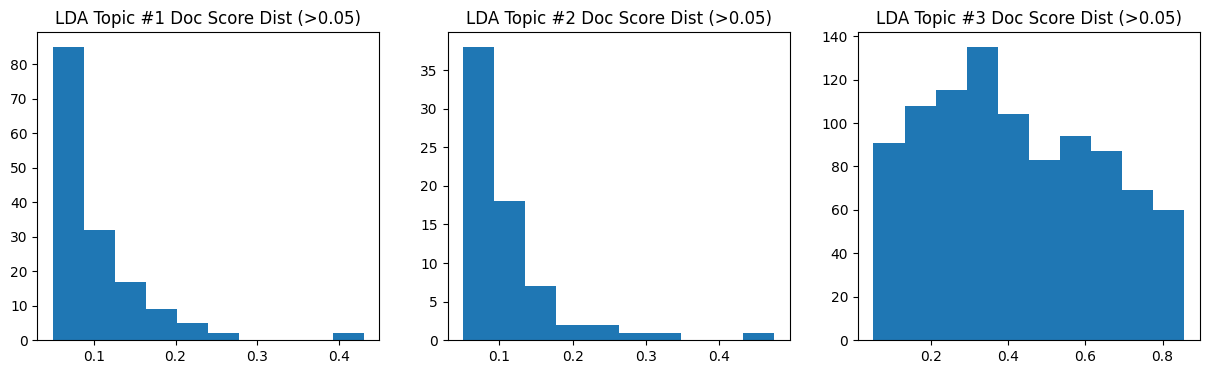

In [60]:
# LDA Topic documents for topics 0-2
plt.figure(figsize=(15,4))
for i in range(3):
    series = pd.Series(text_lda[:,i])
    plt.subplot(1,3,i+1)
    plt.hist(series[series > 0.05])
    plt.title('LDA Topic #{} Doc Score Dist (>0.05)'.format(i+1))
plt.show()

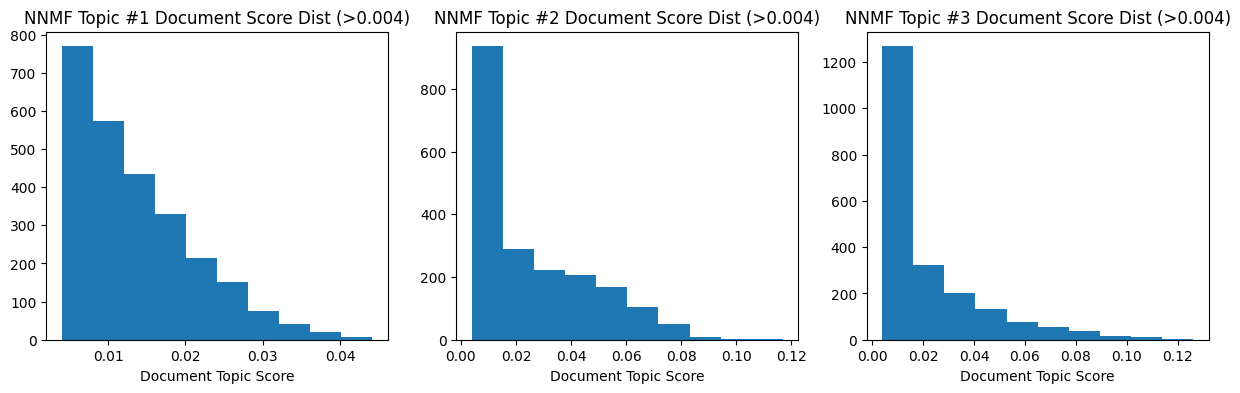

In [61]:
# NNMF Topic documents for topics 0-2
plt.figure(figsize=(15,4))
for i in range(3):
    series = pd.Series(text_nmf[:,i])
    plt.subplot(1,3,i+1)
    plt.hist(series[series > 0.004])
    plt.title('NNMF Topic #{} Document Score Dist (>0.004)'.format(i+1))
    plt.xlabel('Document Topic Score')
#plt.savefig('DocsByTop_Score_Distributions.png', transparent = True)
plt.show()

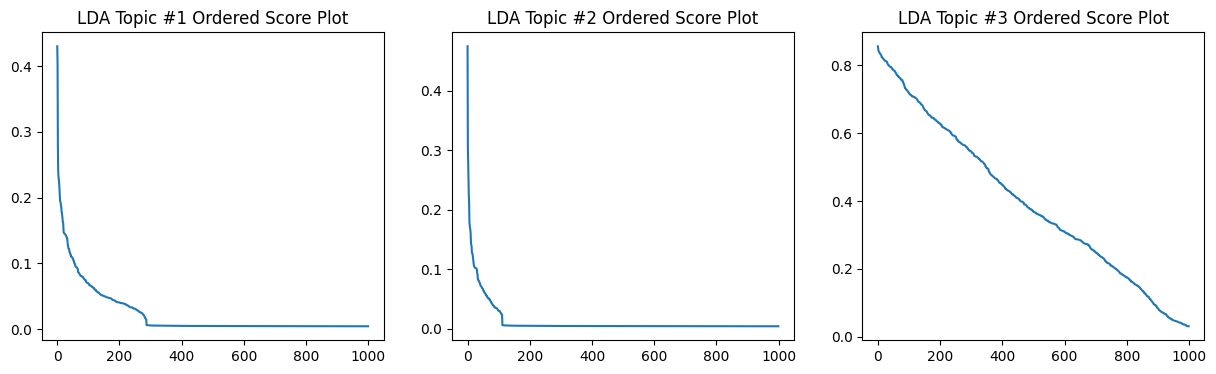

In [62]:
# LDA Topic document scores for topics 0-2
plt.figure(figsize=(15,4))
for i in range(3):
    series = pd.Series(text_lda[:,i]).copy().sort_values(ascending = False).reset_index(drop = True)
    plt.subplot(1,3,i+1)
    plt.plot(series[:1000])
    plt.title('LDA Topic #{} Ordered Score Plot'.format(i+1))
plt.show()

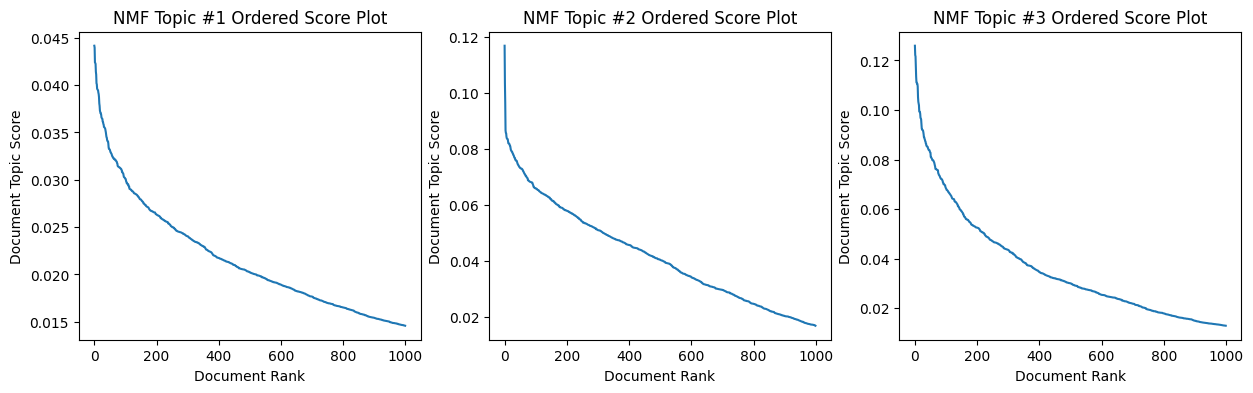

In [63]:
# NMF Topic document scores for topics 0-2
plt.figure(figsize=(15,4))
for i in range(3):
    series = pd.Series(text_nmf[:,i]).copy().sort_values(ascending = False).reset_index(drop = True)
    plt.subplot(1,3,i+1)
    plt.plot(series[:1000])
    plt.title('NMF Topic #{} Ordered Score Plot'.format(i+1))
    plt.xlabel('Document Rank')
    plt.ylabel('Document Topic Score')
#plt.savefig('DocsByTop_Score_Elbows.png', transparent = True)
plt.show()

### Querying Algorithm

In [64]:
recipes.columns

Index(['title', 'ingredients', 'picture_link', 'instructions',
       'ingredient_text', 'ingredient_count'],
      dtype='object')

In [65]:
# Creating TF-IDF Matrices and recalling text dependencies

'''import text_tokenized.csv here'''

# TF-IDF vectorizer instance
vectorizer = TfidfVectorizer(lowercase = True, ngram_range = (1,1))

text_tfidf = vectorizer.fit_transform(tokenized_text)
title_tfidf = vectorizer.transform(recipes['title'])
# text_tfidf    <== Variable with recipe ingredients and instructions
# tags_tfidf = vectorizer.transform(recipes['tags'])
# recipes   <== DataFrame; For indexing and printing recipes

# Query Similarity Weights
w_title = .2
w_text = .3
w_categories = .5


In [66]:
def qweight_array(query_length, qw_array = [1]):
    '''Returns descending weights for ranked query ingredients'''
    if query_length > 1:
        to_split = qw_array.pop()
        split = to_split/2
        qw_array.extend([split, split])
        return qweight_array(query_length - 1, qw_array)
    else:
        return np.array(qw_array)

def ranked_query(query):
    '''Called if query ingredients are ranked in order of importance.
    Weights and adds each ranked query ingredient vector.'''
    query = [[q] for q in query]      # place words in seperate documents
    q_vecs = [vectorizer.transform(q) for q in query]
    qw_array = qweight_array(len(query),[1])
    q_weighted_vecs = q_vecs * qw_array
    q_final_vector = np.add.reduce(q_weighted_vecs)
    return q_final_vector

def overall_scores(query_vector):
    '''Calculates Query Similarity Scores against recipe title, instructions, and keywords.
    Then returns weighted averages of similarities for each recipe.'''
    final_scores = title_tfidf*query_vector.T*w_title
    final_scores += text_tfidf*query_vector.T*w_text
    # final_scores += tags_tfidf*query_vector.T*w_categories
    return final_scores

def print_recipes(index, query, recipe_range):
    '''Prints recipes according to query similary ranks'''
    print('Search Query: {}\n'.format(query))
    for i, index in enumerate(index, recipe_range[0]):
        print('Recipe Rank: {}\t'.format(i+1),recipes.loc[index, 'title'],'\n')
        print('Ingredients:\n{}\n '.format(recipes.loc[index, 'ingredient_text']))
        print('Instructions:\n{}\n'.format(recipes.loc[index, 'instructions']))

def Search_Recipes(query, query_ranked=False, recipe_range=(0,3)):
    '''Master Recipe Search Function'''
    if query_ranked == True:
        q_vector = ranked_query(query)
    else:
        q_vector = vectorizer.transform([' '.join(query)])
    recipe_scores = overall_scores(q_vector)
    sorted_index = pd.Series(recipe_scores.toarray().T[0]).sort_values(ascending = False)[recipe_range[0]:recipe_range[1]].index
    return print_recipes(sorted_index, query, recipe_range)


### Testing the Algorithm

In [67]:
query = ['cinnamon', 'cream', 'banana']
Search_Recipes(query, query_ranked=True, recipe_range=(0,3))

Search Query: ['cinnamon', 'cream', 'banana']

Recipe Rank: 1	 Cinnamon Bread 

Ingredients:
1/4 c. vegetable oil; 1 egg; 1 c. sugar; 1 tsp. soda; 1 c. buttermilk; 2 c. flour; 1/2 tsp. salt
 
Instructions:
Mix and put 1/2 dough in greased pan. Mix 1 tablespoon cinnamon in 1/2 cup sugar. Sprinkle 1/2 of this mixture over dough. Add rest of dough and sprinkle with rest of cinnamon mixture. Run knife through dough. Bake 45 minutes at 375°. Makes 1 loaf.

Recipe Rank: 2	 Cinnamon Pecans 

Ingredients:
2 egg whites; 1 lb. pecan halves; 1 c. sugar; 2 to 3 Tbsp. cinnamon; 1/2 tsp. salt
 
Instructions:
Beat 2 egg whites until foamy. Add pecan halves; mix until foamy. Set aside.

Recipe Rank: 3	 Cinnamon Caramel Rolls 

Ingredients:
2 loaves frozen bread; 1/2 c. butter; 1/2 tsp. cinnamon; 1 c. brown sugar (I use 1/2 c.); 1/2 c. white sugar; 3/4 to 1 c. ice cream
 
Instructions:
Thaw bread slightly. Cut in half and then in half again (lengthwise). Cut into cubes and roll in sugar and cinnamon. P

In [68]:
# Test Rank
query = ['wine', 'cilantro','butter']
Search_Recipes(query, query_ranked=False, recipe_range=(0,3))

Search Query: ['wine', 'cilantro', 'butter']

Recipe Rank: 1	 Mushroom Wine Sauce 

Ingredients:
2 Tbsp. butter; 2 Tbsp. flour; 1 c. chicken stock; 1/2 c. dry white wine; 1/2 tsp. tarragon; salt and pepper; 4 oz. can mushroom pieces or 1/4 lb. fresh, sliced and sauteed for 5 minutes in butter; 1/2 c. half and half; 1 egg yolk
 
Instructions:
Melt butter in saucepan and add flour. Cook, without browning, stirring constantly, for several minutes. Slowly add stock, wine and spices. Simmer several minutes and add mushrooms. Simmer for 5 minutes. Remove from heat and stir in creamed mixed with egg yolk. Cook, stirring, until heated through. Do not let boil. May be made a day ahead and reheated.

Recipe Rank: 2	 Wine Biscuits 

Ingredients:
5 c. flour; 2 eggs; 1 c.oil; 1 c. sugar; 1 c. wine; pinch of salt; 4 tsp. baking powder
 
Instructions:
Place all ingredients in bowl, mix well and shape in desired shape. Bake at 350° for 15 to 20 minutes.

Recipe Rank: 3	 Mulled Wine 

Ingredients:
1 sm

### -- Conclusions and Model Outlook --


In [69]:
# Test
query = ['jelly','wine']
Search_Recipes(query, query_ranked=False, recipe_range=(0,3))

Search Query: ['jelly', 'wine']

Recipe Rank: 1	 Pepper Jelly 

Ingredients:
1/4 c. ground hot peppers; 3/4 c. ground bell pepper; 1 1/2 c. cider vinegar; 1 bottle Certo; 6 c. sugar
 
Instructions:
Boil until sugar dissolves. Let stand 4 minutes; stir in Certo and put in jars. (Turn jars upside down occasionally so that peppers will be evenly distributed throughout jelly when it jells.)

Recipe Rank: 2	 Jelly Roll 

Ingredients:
1 c. flour; 1 tsp. baking powder; 1/4 tsp. salt; 3 large eggs (2/3 c.); 1 c. sugar; 1/3 c. water; 1 tsp. vanilla
 
Instructions:
Preheat oven to 375°. Grease jelly roll pan and line with aluminum foil. Blend flour, baking powder and salt. Set aside. Beat eggs in small bowl until thick and lemon colored. Pour eggs into large bowl. Gradually beat in sugar. Blend in water and vanilla on low speed. Slowly mix in dry ingredients until batter is smooth. Pour into pan. Bake 12 to 15 minutes. Loosen edges and turn upside-down on towel sprinkled with confectioners sugar

In [70]:
query = ['pepper','apple','pork']
Search_Recipes(query, query_ranked=False, recipe_range=(0,3))

Search Query: ['pepper', 'apple', 'pork']

Recipe Rank: 1	 Apple Butter 

Ingredients:
4 lb. apples; 1 c. apple juice or cider; 2 c. sugar; 1 tsp. cinnamon; 1/2 tsp. nutmeg; 1/2 tsp. ground cloves
 
Instructions:
Wash and core apples; cut in 8ths. Put 1/3 cup cider or apple juice and 5 or 6 pieces of apple into blender. Cover and process until smooth. Increase speed to blender. Remove cap and add apple pieces until container is full. Empty into saucepan. Repeat with remaining cider and apples. Add sugar and spices to apples. Cook over low heat about 45 minutes, stirring slightly. Pour into jars. Process 10 minutes in boiling water.

Recipe Rank: 2	 Baked Pork Tenderloin 

Ingredients:
3 lb. pork tenderloin roast; 1 tsp. salt; 1/2 tsp. pepper; 6 slices bacon; 2 c. apple juice; 1/2 tsp. cinnamon; 1/2 tsp. cloves
 
Instructions:
Preheat oven to 325°. Place pork roast in shallow roasting pan; sprinkle with salt and pepper. Arrange bacon on pork. In small saucepan combine apple juice, cinna

In [71]:
### No Category Weight
query = ['cream','banana','cinnamon']
Search_Recipes(query, query_ranked=False, recipe_range=(0,3))

Search Query: ['cream', 'banana', 'cinnamon']

Recipe Rank: 1	 Banana Bread 

Ingredients:
1 stick margarine; 1 c. sugar; 2 eggs; 3 large bananas; 1/2 c. chopped nuts; 2 c. flour; 1 tsp. soda; 1/8 tsp. salt; 1 Tbsp. buttermilk
 
Instructions:
Mix all together. Bake at 250° for 1 1/2 hours.

Recipe Rank: 2	 Banana Bread 

Ingredients:
1/4 c. oleo; 1 c. sugar; 2 eggs; 2 or 3 bananas; 2 c. plain flour; 1 tsp. vanilla; 1 tsp. soda; 1/2 c. nuts, chopped
 
Instructions:
Cream oleo and sugar. Add flavoring and well beaten eggs. Add mashed bananas. Sift flour and soda. Add to mixture. Fold in nuts! Serve with cream cheese. Bake at 300° for 45 minutes.

Recipe Rank: 3	 Banana Cake 

Ingredients:
1 1/2 c. sugar; 1/2 c. shortening; 2 eggs; 2 1/2 c. all-purpose flour; 4 large bananas (ripe); 4 Tbsp. sour milk (sour cream is better); 1 tsp. soda; 1 heaping tsp. baking powder
 
Instructions:
Mash bananas in a bowl and add sour milk or cream. Sprinkle soda over this. Cream sugar, shortening and eggs.

In [72]:
### Empty Query
query = []
Search_Recipes(query, query_ranked=False, recipe_range=(0,3))

Search Query: []

Recipe Rank: 1	 No-Bake Nut Cookies 

Ingredients:
1 c. firmly packed brown sugar; 1/2 c. evaporated milk; 1/2 tsp. vanilla; 1/2 c. broken nuts (pecans); 2 Tbsp. butter or margarine; 3 1/2 c. bite size shredded rice biscuits
 
Instructions:
In a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine. Stir over medium heat until mixture bubbles all over top. Boil and stir 5 minutes more. Take off heat. Stir in vanilla and cereal; mix well. Using 2 teaspoons, drop and shape into 30 clusters on wax paper. Let stand until firm, about 30 minutes.

Recipe Rank: 2	 Beef Enchiladas 

Ingredients:
1 lb. ground beef; 1 1/2 c. grated Cheddar cheese; 1/2 c. chopped onion; 1 can cream of mushroom soup; 1 can tomato soup; 1 (10 oz.) mild enchilada sauce; 12 flour tortillas; 1 pkg. taco seasoning
 
Instructions:
Brown ground beef and drain. Add onion and taco seasoning according to package directions. Add 1/2 cup grated cheese to meat and onion mixtur

In [73]:
### Only Category Weight
query = ['apple','blueberry']
Search_Recipes(query, query_ranked=False, recipe_range=(0,3))

Search Query: ['apple', 'blueberry']

Recipe Rank: 1	 Blueberry Coffee Cake 

Ingredients:
3/4 c. sugar; 1/4 c. Crisco; 1 egg; 1/2 c. milk; 2 c. flour; 2 tsp. baking powder; 1/2 tsp. salt; 2 c. drained blueberries
 
Instructions:
Mix the first 7 ingredients first, then add blueberries; stir by hand. Bake at 375° for 45 to 50 minutes.

Recipe Rank: 2	 Blueberry Muffins 

Ingredients:
1/4 c. shortening; 1/2 c. sugar; 1/2 tsp. baking powder; 1/2 c. flour; 1/2 c. milk; 1 egg; 1/2 tsp. salt; 1 c. blueberries
 
Instructions:
Combine all ingredients, except the blueberries, and mix well. Stir in berries. Pour in muffin cup pan. Bake at 375° for 20 to 25 minutes.

Recipe Rank: 3	 Blueberry Sauce 

Ingredients:
1 qt. grape juice; 2 to 4 Tbsp. arrowroot powder or cornstarch; 2 c. frozen blueberries
 
Instructions:
Heat juice and arrowroot powder until thickened. Stir in blueberries and serve over toast or waffles.



In [74]:
### Only Category Weight
query = ['japanese']
Search_Recipes(query, query_ranked=False, recipe_range=(0,3))

Search Query: ['japanese']

Recipe Rank: 1	 Japanese Fruit Pie 

Ingredients:
1 c. sugar; 3 eggs; 1 Tbsp. lemon juice; 1 stick butter, melted; 1/2 c. raisins; 1/2 c. pecans; 1/2 c. coconut
 
Instructions:
Mix well and pour into unbaked pie shell. Bake at 325° for 40 minutes.

Recipe Rank: 2	 Japanese Fruit Pie 

Ingredients:
2 eggs; 1 stick melted margarine; 1 c. sugar; 1/2 c. raisins; 1/2 c. chopped pecans; 1/2 c. coconut; pinch of salt; 1 Tbsp. vinegar
 
Instructions:
Combine ingredients and pour into unbaked pie shell. Bake at 350° for 40 minutes.

Recipe Rank: 3	 Japanese Fruit Pie 

Ingredients:
1 c. white sugar; 2 eggs; 1 stick margarine, melted; 1/2 c. flaked coconut; 1/2 c. pecans; 1/2 c. raisins; 1 Tbsp. vinegar
 
Instructions:
Mix all ingredients together in order given. Pour into unbaked 9-inch pie shell	and bake at 300° for 30 to 40 minutes.



In [75]:
pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 5.9 MB/s eta 0:00:00


In [76]:
import streamlit as st

In [84]:
! streamlit run recipe_recommendation_system_py.py & npx localtunnel --port 8501



Need to install the following packages:
  localtunnel@2.0.2
Ok to proceed? (y) 
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.82.8.196:8501

  Stopping...
^C


In [86]:
import marshal
code_string = marshal.dumps(Search_Recipes.__code__)
code_string

b'\xe3\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x06\x00\x00\x00\x05\x00\x00\x00C\x00\x00\x00sf\x00\x00\x00|\x01d\x01k\x02r\tt\x00|\x00\x83\x01}\x03n\tt\x01\xa0\x02d\x02\xa0\x03|\x00\xa1\x01g\x01\xa1\x01}\x03t\x04|\x03\x83\x01}\x04t\x05\xa0\x06|\x04\xa0\x07\xa1\x00j\x08d\x03\x19\x00\xa1\x01j\td\x04d\x05\x8d\x01|\x02d\x03\x19\x00|\x02d\x06\x19\x00\x85\x02\x19\x00j\n}\x05t\x0b|\x05|\x00|\x02\x83\x03S\x00)\x07\xfa\x1dMaster Recipe Search FunctionT\xda\x01 \xe9\x00\x00\x00\x00F)\x01\xda\tascending\xe9\x01\x00\x00\x00)\x0c\xda\x0cranked_query\xda\nvectorizer\xda\ttransform\xda\x04join\xda\x0eoverall_scores\xda\x02pd\xda\x06Series\xda\x07toarray\xda\x01T\xda\x0bsort_values\xda\x05index\xda\rprint_recipes)\x06\xda\x05query\xda\x0cquery_ranked\xda\x0crecipe_range\xda\x08q_vector\xda\rrecipe_scores\xda\x0csorted_index\xa9\x00r\x18\x00\x00\x00\xfa\x1f<ipython-input-66-205f2d8d2177>\xda\x0eSearch_Recipes%\x00\x00\x00s\x0c\x00\x00\x00\x08\x02\n\x01\x12\x02\x08\x01.\x01\x0c\x01'

In [88]:
import types

code = marshal.loads(code_string)
func = types.FunctionType(code, globals(), "some_func_name")

func(['blueberry'], query_ranked=False, recipe_range=(0,3))  # gives 100

Search Query: ['blueberry']

Recipe Rank: 1	 Blueberry Coffee Cake 

Ingredients:
3/4 c. sugar; 1/4 c. Crisco; 1 egg; 1/2 c. milk; 2 c. flour; 2 tsp. baking powder; 1/2 tsp. salt; 2 c. drained blueberries
 
Instructions:
Mix the first 7 ingredients first, then add blueberries; stir by hand. Bake at 375° for 45 to 50 minutes.

Recipe Rank: 2	 Blueberry Muffins 

Ingredients:
1/4 c. shortening; 1/2 c. sugar; 1/2 tsp. baking powder; 1/2 c. flour; 1/2 c. milk; 1 egg; 1/2 tsp. salt; 1 c. blueberries
 
Instructions:
Combine all ingredients, except the blueberries, and mix well. Stir in berries. Pour in muffin cup pan. Bake at 375° for 20 to 25 minutes.

Recipe Rank: 3	 Blueberry Sauce 

Ingredients:
1 qt. grape juice; 2 to 4 Tbsp. arrowroot powder or cornstarch; 2 c. frozen blueberries
 
Instructions:
Heat juice and arrowroot powder until thickened. Stir in blueberries and serve over toast or waffles.

